In [35]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import helper 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.datasets import make_classification

## Data Modeling Workflow
The following workflow will be applied in building the data model:
1.  Extract tests at assessment and weeks 0 - 4 for treatment<br>
2.  Extract surveys at assessment and weeks 0, 4 for treatment
3.  Extract Other Numeric Baseline Predictors, including:
    - attendence
    - medication dose
    - clinical opiate withdrawal scale - score of 1 - 13, lower score shows lower withdrawal symptoms
4.  Extract Catagorical Baseline Predictors, including:
    - Demographics
    - Substance Use Diagnosis
    - Mental and Pysical Health History
    - Physical Exam

## Load Data

In [36]:
# read csv file
data = pd.read_csv('../data/merged_data.csv')

print('Shape of dataframe prior to modeling:', data.shape)
display(data.head())

Shape of dataframe prior to modeling: (1321, 420)


,patdeid,rsa_week_0,rsa_week_1,rsa_week_2,rsa_week_3,rsa_week_4,rsa_week_5,rsa_week_6,rsa_week_7,rsa_week_8,...,pex_neurological,pex_gen_appearance,pex_ears_nose_throat,pex_head_neck,pex_cardio,pex_skin,medication,weeks_attended,cows_predose,cows_postdose
0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,normal,normal,normal,normal,normal,normal,2.0,27,11.0,6.0
1,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,normal,abnormal,abnormal,normal,normal,abnormal,2.0,27,8.0,1.0
2,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,normal,normal,normal,normal,normal,abnormal,1.0,27,8.0,5.0
3,4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,normal,normal,normal,normal,normal,normal,2.0,27,11.0,9.0
4,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,normal,abnormal,abnormal,normal,normal,abnormal,2.0,3,11.0,6.0


In [37]:
data = data.loc[data['medication']==2]

## Review Tests

In [38]:
test_names = [
 #'Propoxyphene',
 #'Amphetamines',
 #'Cannabinoids',
 #'Benzodiazepines',
 #'MMethadone',
 #'Oxycodone',
 #'Cocaine',
 #'Methamphetamine',
 'Opiate300'
 ]

# define prefix parameter and call helper function to build the dataset
prefix = 'test_'
tests = helper.feature_selection(data, prefix, test_names)

Shape of tests DataFrame: (769, 5)


,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4
0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,0.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...
1315,1.0,1.0,1.0,1.0,1.0
1316,1.0,1.0,1.0,1.0,1.0
1318,1.0,1.0,1.0,1.0,1.0
1319,1.0,1.0,1.0,1.0,1.0


## Review Surveys


In [39]:
# comment out the drugs you don't want to include
survey_names = [
#'cannabis',
#'cocaine',
#'alcohol',
#'oxycodone',
#'mmethadone',
#'amphetamine',
#'methamphetamine',
'opiates',
#'benzodiazepines'
]

# call helper function to build  the dataset
prefix = 'survey_'
surveys = helper.feature_selection(data, prefix, survey_names)

Shape of tests DataFrame: (769, 2)


,survey_opiates_0,survey_opiates_4
0,30.0,0.0
1,30.0,5.0
3,30.0,6.0
4,5.0,0.0
5,29.0,0.0
...,...,...
1315,30.0,0.0
1316,20.0,0.0
1318,30.0,0.0
1319,30.0,0.0


## Create Dataframe for Baseline Numeric Predictors

In [40]:
# attendance data, included up to week 4
#rsa = data[[col for col in data.columns if 'rsa' in col]].iloc[:, :5]

# medication data, included up to week 4
group = 'meds_buprenorphine'
meds = data[[col for col in data.columns if group in col]].iloc[:, :5]

# clinical opiate withdrawal scale -  included for baseline and week 0
cows = data[[col for col in data.columns if 'cows' in col]]

# create dataframe with numeric features
num_df = pd.concat([tests, surveys, meds, cows], axis=1)

print('Shape of numeric dataframe',num_df.shape)
display(num_df)

Shape of numeric dataframe (769, 14)


,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4,survey_opiates_0,survey_opiates_4,meds_buprenorphine_0,meds_buprenorphine_1,meds_buprenorphine_2,meds_buprenorphine_3,meds_buprenorphine_4,cows_predose,cows_postdose
0,1.0,0.0,0.0,0.0,0.0,30.0,0.0,8.0,160.0,320.0,192.0,384.0,11.0,6.0
1,1.0,1.0,1.0,1.0,1.0,30.0,5.0,8.0,48.0,48.0,60.0,48.0,8.0,1.0
3,1.0,1.0,0.0,1.0,1.0,30.0,6.0,16.0,152.0,192.0,160.0,64.0,11.0,9.0
4,1.0,1.0,1.0,1.0,1.0,5.0,0.0,16.0,16.0,16.0,0.0,0.0,11.0,6.0
5,1.0,1.0,1.0,1.0,1.0,29.0,0.0,8.0,8.0,140.0,0.0,92.0,18.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,1.0,1.0,1.0,1.0,1.0,30.0,0.0,16.0,0.0,0.0,0.0,0.0,26.0,0.0
1316,1.0,1.0,1.0,1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0
1318,1.0,1.0,1.0,1.0,1.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0
1319,1.0,1.0,1.0,1.0,1.0,30.0,0.0,2.0,0.0,0.0,0.0,0.0,16.0,0.0


## Review Categorical Data

In [41]:
# demographic data
#dem = data[[col for col in data.columns if col.startswith('dem_')]]
#dem = pd.get_dummies(dem, dtype=int)
# create df for diagnosis
dsm = data[[col for col in data.columns if col.startswith('dsm_')]]
#dsm = pd.get_dummies(dsm, dtype=int)
# create df for medical history
mdh = data[[col for col in data.columns if col.startswith('mdh_')]]
#mdh = pd.get_dummies(mdh, dtype=int)

# create df for physical exam
pex = data[[col for col in data.columns if col.startswith('pex_')]]
#pex = pd.get_dummies(pex, dtype=int)

# concat cat features into cat_df
cat_df = pd.concat([dsm, mdh, pex], axis=1)
print('shape of the categorical df:',cat_df.shape)
display(cat_df)

shape of the categorical df: (769, 36)


,dsm_cannabis,dsm_cocaine,dsm_sedative,dsm_opiates,dsm_alcohol,dsm_amphetamine,mdh_liver_problems,mdh_kidney_problems,mdh_alc_withdrawal,mdh_schizophrenia,...,pex_respiratory,pex_musculoskeletal,pex_gi_system,pex_extremeties,pex_neurological,pex_gen_appearance,pex_ears_nose_throat,pex_head_neck,pex_cardio,pex_skin
0,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis,yes_history,no_history,no_history,no_history,...,normal,abnormal,abnormal,normal,normal,normal,normal,normal,normal,normal
1,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis,no_history,no_history,no_history,no_history,...,normal,normal,abnormal,normal,normal,abnormal,abnormal,normal,normal,abnormal
3,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis,no_history,no_history,no_history,no_history,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
4,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis,no_history,no_history,no_history,no_history,...,normal,normal,abnormal,abnormal,normal,abnormal,abnormal,normal,normal,abnormal
5,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis,no_history,no_history,no_history,no_history,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,not_present,not_present,not_present,not_present,not_present,not_present,no_history,no_history,no_history,no_history,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
1316,no_diagnosis,no_diagnosis,no_diagnosis,dependence,no_diagnosis,no_diagnosis,no_history,no_history,no_history,no_history,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,normal
1318,no_diagnosis,dependence,no_diagnosis,dependence,abuse,no_diagnosis,no_history,no_history,yes_history,no_history,...,abnormal,abnormal,normal,normal,normal,normal,normal,normal,normal,normal
1319,abuse,dependence,no_diagnosis,dependence,no_diagnosis,dependence,no_history,no_history,no_history,no_history,...,normal,normal,normal,abnormal,normal,normal,normal,normal,normal,abnormal


### We found some noisy data in this dataset
There were two different imputations applied to dsm columns<br>
Combine 'not_present' and 'not_evaluated' to 'not_evaluated'<br>
There is a 0 value in `dem_gender` in 3 rows, we will delete them<br>

In [42]:
# replace values labeled 'not_present', with 'not_evaluated'
#cat_df = cat_df.replace('not_present', 'not_evaluated')

# remove rows with 0 values
#cat_df.loc[cat_df.dem_gender!='0']

#print(cat_df.shape)
#display(cat_df)

In [43]:
# one hot encode cat_df
cat_df = pd.get_dummies(cat_df, drop_first=True, dtype=float)

print(cat_df.shape)
display(cat_df)

(769, 93)


,dsm_cannabis_dependence,dsm_cannabis_no_diagnosis,dsm_cannabis_not_evaluated,dsm_cannabis_not_present,dsm_cocaine_dependence,dsm_cocaine_no_diagnosis,dsm_cocaine_not_evaluated,dsm_cocaine_not_present,dsm_sedative_dependence,dsm_sedative_no_diagnosis,...,pex_ears_nose_throat_not_present,pex_head_neck_normal,pex_head_neck_not_evaluated,pex_head_neck_not_present,pex_cardio_normal,pex_cardio_not_evaluated,pex_cardio_not_present,pex_skin_normal,pex_skin_not_evaluated,pex_skin_not_present
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1316,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1318,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1319,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [44]:
top_features = pd.read_csv('../data/top_features.csv')

top_features_df = data[[col for col in data.columns if col in top_features['feature'].values]]

# concat all dataframes


## Assign Target Variable and Combine

In [45]:
# assigne dropout variable
dropout = data['dropout']

# merge
new_data = pd.concat([num_df, cat_df, top_features_df, dropout], axis=1)

print('Shape of new datframe:',new_data.shape)
display(new_data)


Shape of new datframe: (769, 123)


,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4,survey_opiates_0,survey_opiates_4,meds_buprenorphine_0,meds_buprenorphine_1,meds_buprenorphine_2,...,test_Cannabinoids_4,test_MMethadone_4,survey_alcohol_0,survey_oxycodone_0,survey_mmethadone_0,survey_cannabis_4,survey_cocaine_4,survey_methamphetamine_4,survey_benzodiazepines_4,dropout
0,1.0,0.0,0.0,0.0,0.0,30.0,0.0,8.0,160.0,320.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,30.0,5.0,8.0,48.0,48.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,1.0,1.0,30.0,6.0,16.0,152.0,192.0,...,1.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0
4,1.0,1.0,1.0,1.0,1.0,5.0,0.0,16.0,16.0,16.0,...,1.0,1.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,1.0
5,1.0,1.0,1.0,1.0,1.0,29.0,0.0,8.0,8.0,140.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,1.0,1.0,1.0,1.0,1.0,30.0,0.0,16.0,0.0,0.0,...,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0
1316,1.0,1.0,1.0,1.0,1.0,20.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0
1318,1.0,1.0,1.0,1.0,1.0,30.0,0.0,0.0,0.0,0.0,...,1.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1319,1.0,1.0,1.0,1.0,1.0,30.0,0.0,2.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [46]:
#top_features = pd.read_csv('../data/top_features.csv')

# create df with features from feature column
#top_features = data[[col for col in data.columns if col in top_features['feature'].values]]

# concat top features with new_data
#new_data = pd.concat([new_data, top_features], axis=1)

#print('Shape of new datframe:',new_data.shape)
#display(new_data)

## Classification Workflow

In [47]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import numpy as np


# create train, test and eval set
from fast_ml.model_development import train_valid_test_split
train = 0.7
test = 0.2
validation = 0.1
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(new_data,
                      target='dropout',
                      train_size=train,                        
                      test_size=test,
                      valid_size=validation)

# print shape of all data sets
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (538, 122)
Shape of X_val: (77, 122)
Shape of X_test: (154, 122)


In [48]:
gbm_param_grid = {
	'learning_rate': [0.01, 0.1, 0.5, 0.9],
	'n_estimators': [200, 300, 400],
    'max_depth': [3, 6, 9],
	'objective': ['binary:logistic']  # Specify binary logistic objective
}

gbm = xgb.XGBClassifier(use_label_encoder=False)  # XGBClassifier for classification tasks
grid_auc = GridSearchCV(estimator=gbm, 
                        param_grid=gbm_param_grid, 
                        scoring='roc_auc', 
                        cv=5, 
                        verbose=1, 
                        return_train_score=True,
                        n_jobs=-1)  # Use ROC AUC as the scoring metric

grid_auc.fit(X_train, y_train)
print("Best parameters found: ", grid_auc.best_params_)
print("Highest ROC AUC found: ", grid_auc.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'objective': 'binary:logistic'}
Highest ROC AUC found:  0.7936003785475616


In [49]:
# refit the model with the best params
best_params = grid_auc.best_params_

# best model
best_gbm = xgb.XGBClassifier(**best_params)

# fit the model
best_gbm.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)], eval_metric=['auc','error'], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

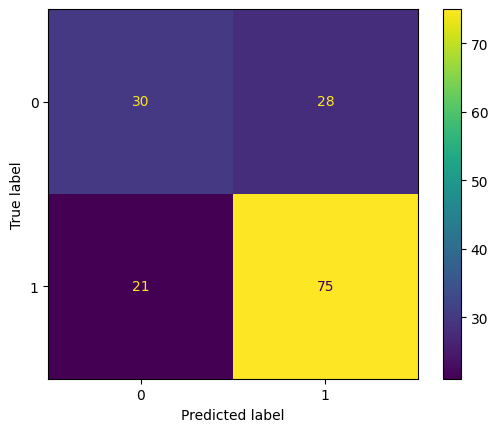

In [50]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = best_gbm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_gbm.classes_)
disp.plot();

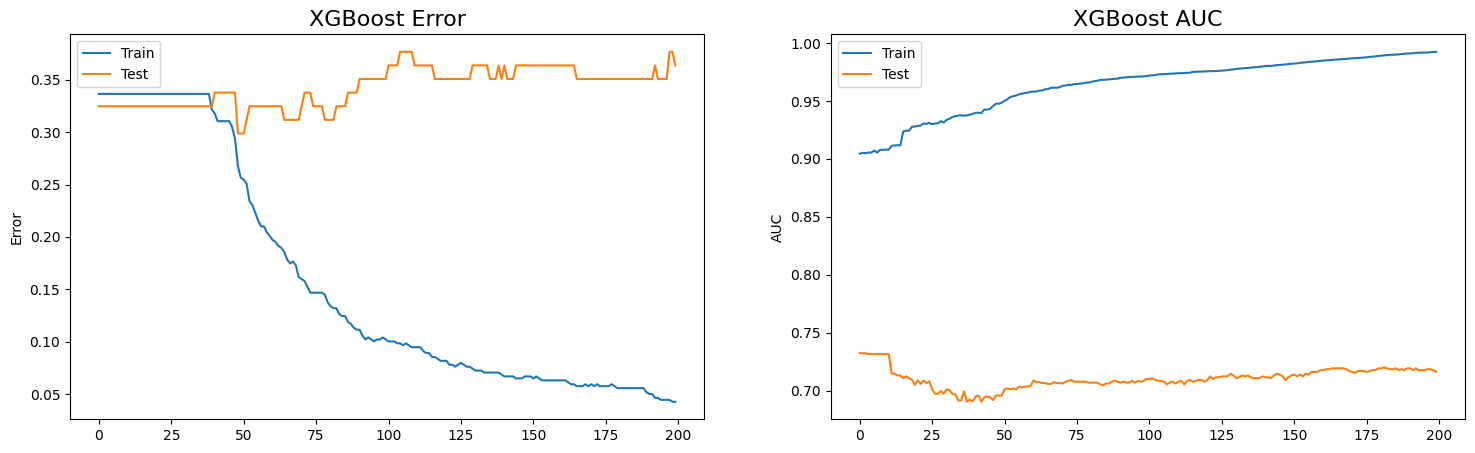

In [51]:
# retrieve performance metrics
results = best_gbm.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss and classification error 
fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

# plot log loss
axs[0].plot(x_axis, results['validation_0']['error'], label='Train')
axs[0].plot(x_axis, results['validation_1']['error'], label='Test')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_title('XGBoost Error', fontsize=16)

# plot classification error
axs[1].plot(x_axis, results['validation_0']['auc'], label='Train')
axs[1].plot(x_axis, results['validation_1']['auc'], label='Test')
axs[1].legend()
axs[1].set_ylabel('AUC')
axs[1].set_title('XGBoost AUC', fontsize=16)

plt.show()


In [52]:
# make predictions to evaluate the model
y_pred_train = best_gbm.predict(X_train)
y_pred_val = best_gbm.predict(X_val)
y_pred_test = best_gbm.predict(X_test)

### Create DF with Train, Val and Test metrics

In [53]:
from sklearn.metrics import classification_report

# Assuming you have your predictions as y_pred_train, y_pred_val, y_pred_test
# and the true labels as y_train, y_val, y_test

# Generate classification reports
report_train = classification_report(y_train, y_pred_train, output_dict=True)
report_val = classification_report(y_val, y_pred_val, output_dict=True)
report_test = classification_report(y_test, y_pred_test, output_dict=True)

# Create DataFrames from reports
df_train = pd.DataFrame(report_train).transpose()
df_val = pd.DataFrame(report_val).transpose()
df_test = pd.DataFrame(report_test).transpose()

# Add a column to distinguish between datasets
df_train['dataset'] = 'Training'
df_val['dataset'] = 'Validation'
df_test['dataset'] = 'Test'

# Concatenate all three DataFrames
df_all = pd.concat([df_train, df_val, df_test], axis=0).reset_index()

# Rename 'index' column to something more descriptive, like 'metric'
df_all.rename(columns={'index': 'metric'}, inplace=True)

# subset columns
#df_all = df_all[['metric','precision','dataset']]

# pivot the dataframe
#df_all = df_all.pivot(index='dataset', columns='metric', values='precision').reset_index()

# reorder rows, 1, 2, 0
#df_all = df_all.reindex([1,2,0])

classification_metrics = df_all.loc[
                                    (df_all['metric']=='0.0') | 
                                    (df_all['metric']=='1.0') |
                                    (df_all['metric']=='macro avg')    
                                ]

classification_metrics

,metric,precision,recall,f1-score,support,dataset
0,0.0,0.924731,0.950276,0.937330,181.0,Training
1,1.0,0.974432,0.960784,0.967560,357.0,Training
3,macro avg,0.949582,0.955530,0.952445,538.0,Training
5,0.0,0.444444,0.480000,0.461538,25.0,Validation
6,1.0,0.740000,0.711538,0.725490,52.0,Validation
8,macro avg,0.592222,0.595769,0.593514,77.0,Validation
10,0.0,0.588235,0.517241,0.550459,58.0,Test
11,1.0,0.728155,0.781250,0.753769,96.0,Test
13,macro avg,0.658195,0.649246,0.652114,154.0,Test


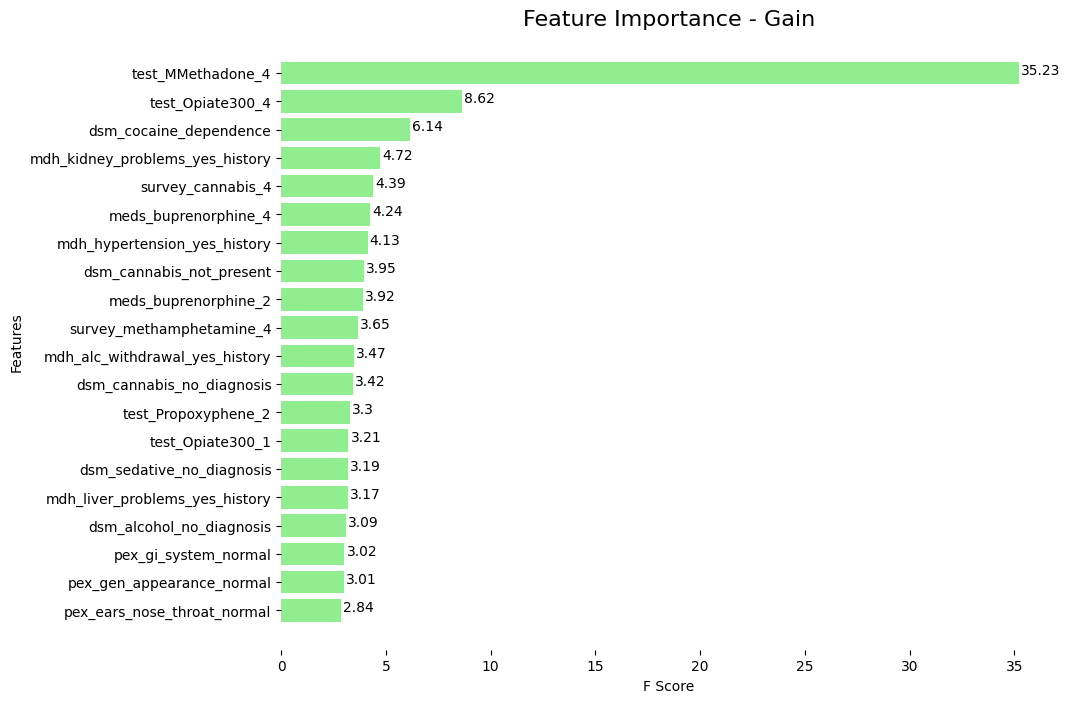

In [54]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming grid_auc.best_estimator_ is your trained XGBoost model
model = grid_auc.best_estimator_

metric='gain'
plot = metric.capitalize().replace('_g', ' G')

# Get feature importances and round them
importances = model.get_booster().get_score(importance_type=metric)
importances_rounded = {k: round(v, 2) for k, v in importances.items()}

# Sort features by importance
sorted_importances = sorted(importances_rounded.items(), key=lambda x: x[1], reverse=True)[:20]

# Separate keys and values for plotting
features, scores = zip(*sorted_importances)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(scores)), scores, color='lightgreen')
plt.yticks(range(len(scores)), features)
plt.xlabel('F Score')
plt.ylabel('Features')
# annotate the values over the bars
for i, v in enumerate(scores):
    plt.text(v + 0.1, i - 0.1, str(v), color='black', va='center')
plt.title(f'Feature Importance - {plot}', fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
# remove borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()

In [55]:
# show the first element of all rows in the tuple
features = [x[0] for x in sorted_importances]

final_predictors = new_data[features+['dropout']]

print(final_predictors.shape)
display(final_predictors)

# save to csv
final_predictors.to_csv('../data/final_predictors.csv', index=False)

(769, 21)


,test_MMethadone_4,test_Opiate300_4,dsm_cocaine_dependence,mdh_kidney_problems_yes_history,survey_cannabis_4,meds_buprenorphine_4,mdh_hypertension_yes_history,dsm_cannabis_not_present,meds_buprenorphine_2,survey_methamphetamine_4,...,dsm_cannabis_no_diagnosis,test_Propoxyphene_2,test_Opiate300_1,dsm_sedative_no_diagnosis,mdh_liver_problems_yes_history,dsm_alcohol_no_diagnosis,pex_gi_system_normal,pex_gen_appearance_normal,pex_ears_nose_throat_normal,dropout
0,0.0,0.0,0.0,0.0,1.0,384.0,0.0,0.0,320.0,2.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
1,0.0,1.0,0.0,0.0,1.0,48.0,0.0,0.0,48.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,2.0,64.0,0.0,0.0,192.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,16.0,0.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
5,1.0,1.0,0.0,0.0,0.0,92.0,0.0,0.0,140.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1316,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
1318,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
1319,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [56]:
# create train, test and eval set
from fast_ml.model_development import train_valid_test_split
train = 0.7
test = 0.2
validation = 0.1
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(final_predictors,
                      target='dropout',
                      train_size=train,                        
                      test_size=test,
                      valid_size=validation)

# print shape of all data sets
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (538, 20)
Shape of X_val: (77, 20)
Shape of X_test: (154, 20)


In [57]:
gbm_param_grid = {
	'learning_rate': [0.01, 0.1, 0.5, 0.9],
	'n_estimators': [200, 300, 400],
    'max_depth': [3, 6, 9],
	'objective': ['binary:logistic']  # Specify binary logistic objective
}

gbm = xgb.XGBClassifier(use_label_encoder=False)  # XGBClassifier for classification tasks
grid_auc = GridSearchCV(estimator=gbm, 
                        param_grid=gbm_param_grid, 
                        scoring='roc_auc', 
                        cv=5, 
                        verbose=1, 
                        return_train_score=True,
                        n_jobs=-1)  # Use ROC AUC as the scoring metric

grid_auc.fit(X_train, y_train)
print("Best parameters found: ", grid_auc.best_params_)
print("Highest ROC AUC found: ", grid_auc.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'objective': 'binary:logistic'}
Highest ROC AUC found:  0.774890500829468


In [58]:
# refit the model with the best params
best_params = grid_auc.best_params_

# best model
best_gbm = xgb.XGBClassifier(**best_params)

# fit the model
best_gbm.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)], eval_metric=['auc','error'], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [59]:
# make predictions to evaluate the model
y_pred_train = best_gbm.predict(X_train)
y_pred_val = best_gbm.predict(X_val)
y_pred_test = best_gbm.predict(X_test)

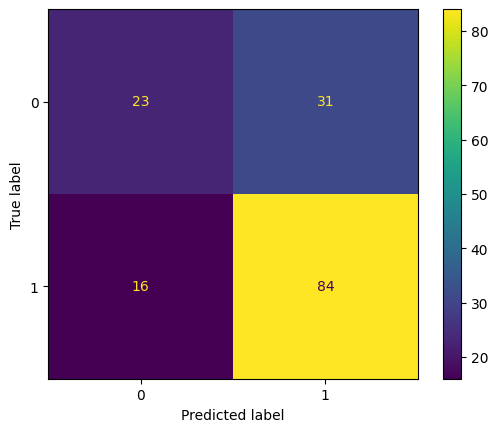

In [60]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = best_gbm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_gbm.classes_)
disp.plot();

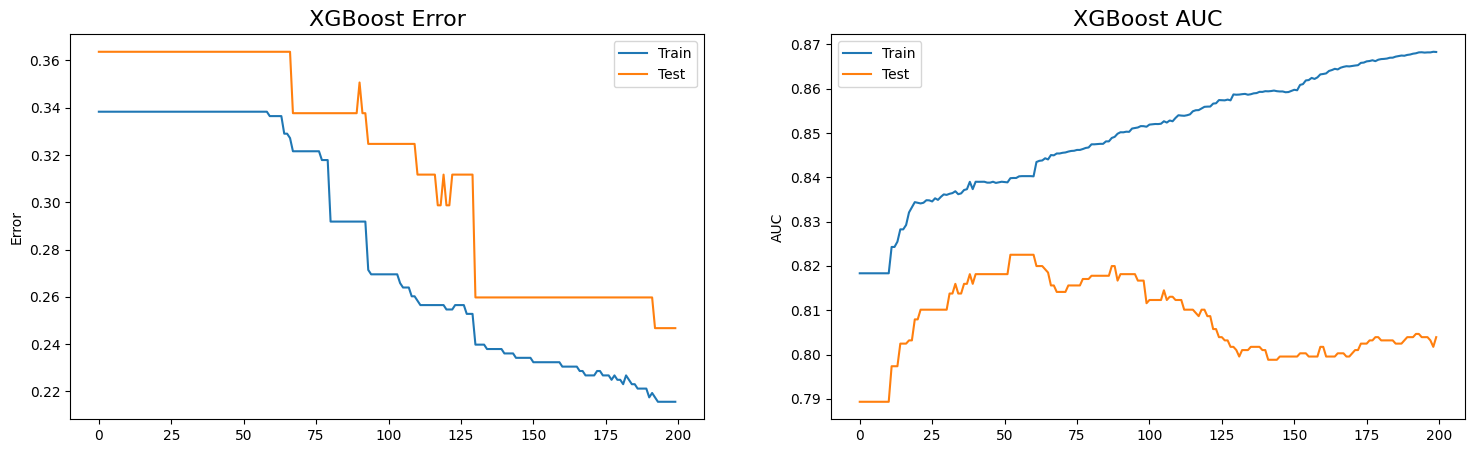

In [61]:
# retrieve performance metrics
results = best_gbm.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss and classification error 
fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

# plot log loss
axs[0].plot(x_axis, results['validation_0']['error'], label='Train')
axs[0].plot(x_axis, results['validation_1']['error'], label='Test')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_title('XGBoost Error', fontsize=16)

# plot classification error
axs[1].plot(x_axis, results['validation_0']['auc'], label='Train')
axs[1].plot(x_axis, results['validation_1']['auc'], label='Test')
axs[1].legend()
axs[1].set_ylabel('AUC')
axs[1].set_title('XGBoost AUC', fontsize=16)

plt.show()


In [62]:
from sklearn.metrics import classification_report

# Assuming you have your predictions as y_pred_train, y_pred_val, y_pred_test
# and the true labels as y_train, y_val, y_test

# Generate classification reports
report_train = classification_report(y_train, y_pred_train, output_dict=True)
report_val = classification_report(y_val, y_pred_val, output_dict=True)
report_test = classification_report(y_test, y_pred_test, output_dict=True)

# Create DataFrames from reports
df_train = pd.DataFrame(report_train).transpose()
df_val = pd.DataFrame(report_val).transpose()
df_test = pd.DataFrame(report_test).transpose()

# Add a column to distinguish between datasets
df_train['dataset'] = 'Training'
df_val['dataset'] = 'Validation'
df_test['dataset'] = 'Test'

# Concatenate all three DataFrames
df_all = pd.concat([df_train, df_val, df_test], axis=0).reset_index()

# Rename 'index' column to something more descriptive, like 'metric'
df_all.rename(columns={'index': 'metric'}, inplace=True)

# subset columns
df_all = df_all[['metric','precision','dataset']]

# pivot the dataframe
df_all = df_all.pivot(index='dataset', columns='metric', values='precision').reset_index()

# reorder rows, 1, 2, 0
df_all = df_all.reindex([1,2,0])

df_all

metric,dataset,0.0,1.0,accuracy,macro avg,weighted avg
1,Training,0.696429,0.824324,0.784387,0.760376,0.781058
2,Validation,0.680000,0.788462,0.753247,0.734231,0.749021
0,Test,0.589744,0.730435,0.694805,0.660089,0.681102


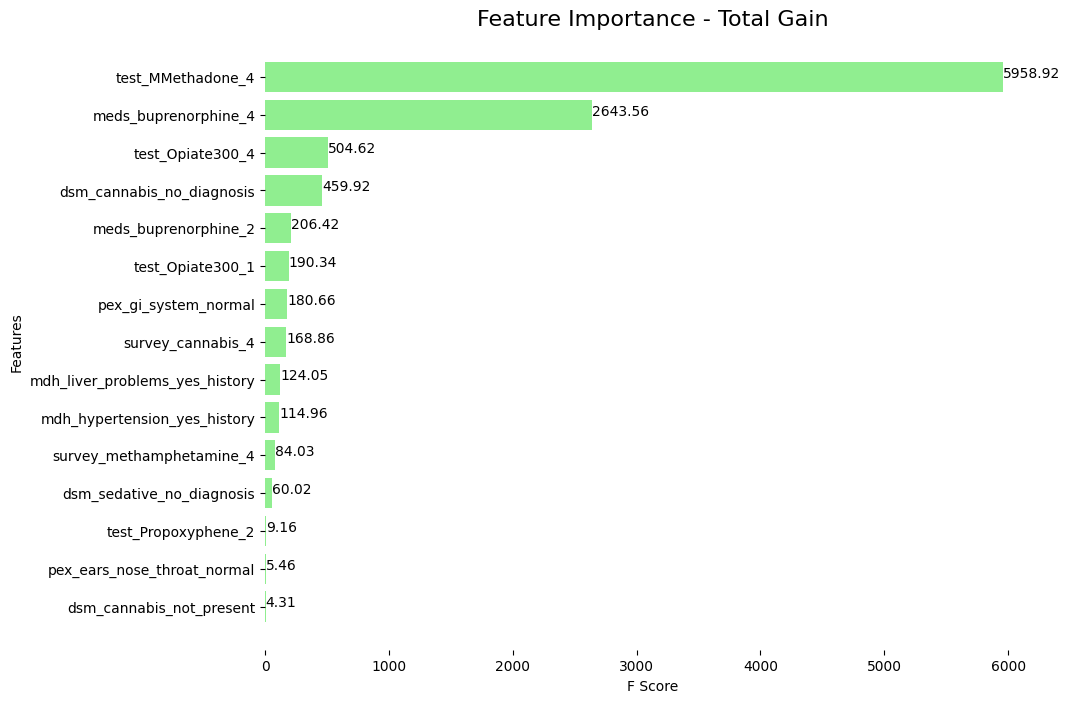

In [63]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming grid_auc.best_estimator_ is your trained XGBoost model
model = grid_auc.best_estimator_

metric='total_gain'
plot = metric.capitalize().replace('_g', ' G')

# Get feature importances and round them
importances = model.get_booster().get_score(importance_type=metric)
importances_rounded = {k: round(v, 2) for k, v in importances.items()}

# Sort features by importance
sorted_importances = sorted(importances_rounded.items(), key=lambda x: x[1], reverse=True)

# Separate keys and values for plotting
features, scores = zip(*sorted_importances)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(scores)), scores, color='lightgreen')
plt.yticks(range(len(scores)), features)
plt.xlabel('F Score')
plt.ylabel('Features')
# annotate the values over the bars
for i, v in enumerate(scores):
    plt.text(v + 0.1, i - 0.1, str(v), color='black', va='center')
plt.title(f'Feature Importance - {plot}', fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
# remove borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()

## Create a DF with all the trees

In [64]:
# Assuming `grid_auc` is your trained GridSearchCV object with an XGBClassifier
best_model = grid_auc.best_estimator_

# Extract the Booster
booster = best_model.get_booster()

# Convert the trees to a DataFrame
trees_df = booster.trees_to_dataframe().iloc[:, :10]

trees_df = trees_df.sort_values(by='Gain', ascending=False)

In [65]:
# observe the different split points for the feature of interest
trees_df.loc[trees_df['Feature']=='meds_buprenorphine_4'].Split.values

array([ 36.,  36.,  36.,  36.,  36.,  36.,  36.,  36.,  36.,  36.,  36.,
        36.,  36.,  36.,  36.,  36.,  36.,  36.,  36.,  36.,  36.,  24.,
        24.,  24.,  24.,  24.,  24.,  24.,  24.,  24.,  24.,  24.,  24.,
        24.,  24.,  24.,  24.,  24.,  66.,  24.,  66.,  24.,  66.,  66.,
        24.,  66.,  66.,  24.,  66.,  66.,  24.,  66.,  24.,  66.,  66.,
        66.,  24.,  66.,  66.,  24.,  66.,  24.,  66.,  66.,  24.,  66.,
        66.,  24.,  66.,  66.,  66.,  24.,  66.,  24.,  66.,  66.,  24.,
        66.,  66.,  66.,  24.,  66.,  66.,  66.,  24.,  66.,  24.,  66.,
        66.,  66.,  66.,  24.,  66.,  66.,  66.,  24.,  66.,  24.,  66.,
        66.,  66.,  24.,  66.,  66.,  66.,  24.,  66.,  66.,  24.,  66.,
        66.,  66.,  24.,  66.,  66.,  66.,  24.,  66.,  66.,  24.,  66.,
        66.,  66.,  66.,  24.,  66.,  24.,  66.,  66.,  66.,  24.,  66.,
        24.,  66.,  66.,  24.,  66.,  24.,  66.,  66.,  66.,  24.,  66.,
        24.,  66.,  66.,  24.,  66.,  66.,  24.,  6

In [66]:
trees_df.loc[trees_df.Feature=='meds_buprenorphine_4'].sort_values(by='Gain', ascending=False)

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
793,61,0,61-0,meds_buprenorphine_4,36.0,61-1,61-2,61-2,42.810471,113.722450
832,64,0,64-0,meds_buprenorphine_4,36.0,64-1,64-2,64-2,40.951225,113.202469
858,66,0,66-0,meds_buprenorphine_4,36.0,66-1,66-2,66-2,39.752323,112.870941
884,68,0,68-0,meds_buprenorphine_4,36.0,68-1,68-2,68-2,38.587994,112.531219
923,71,0,71-0,meds_buprenorphine_4,36.0,71-1,71-2,71-2,36.927799,112.007553
...,...,...,...,...,...,...,...,...,...,...
1358,104,6,104-6,meds_buprenorphine_4,176.0,104-11,104-12,104-12,0.906724,4.384103
1410,108,6,108-6,meds_buprenorphine_4,176.0,108-11,108-12,108-12,0.883237,4.380877
1592,122,6,122-6,meds_buprenorphine_4,176.0,122-11,122-12,122-12,0.816434,4.362076
1741,133,6,133-6,meds_buprenorphine_4,176.0,133-11,133-12,133-12,0.777029,4.353097


## Plot a Specific Estimator


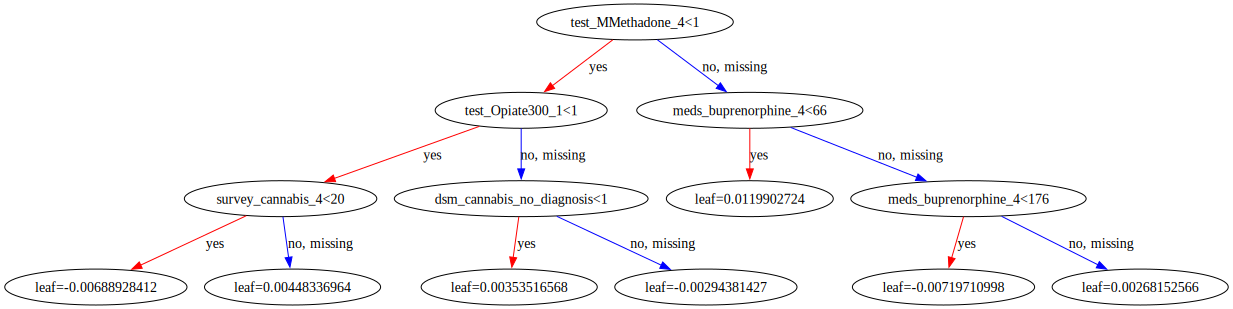

In [67]:
# plot tree with to_graphviz() sideways
graph = xgb.to_graphviz(booster, num_trees=50)
graph

## Analyze Test Set with Predictions

In [68]:
# Assuming `model` is your trained model and `X_test`, `y_test` are your test datasets
predictions = best_gbm.predict(X_test)

# Convert X_test to a DataFrame if it's not already
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Add predictions and actual labels to the DataFrame
X_test_df['Prediction'] = predictions
X_test_df['Actual'] = y_test

# Function to classify each prediction
def classify_prediction(row):
	if row['Prediction'] == row['Actual']:
		return 'TP' if row['Prediction'] == 1 else 'TN'
	else:
		return 'FP' if row['Prediction'] == 1 else 'FN'

# Apply the function to classify predictions
X_test_df['Classification'] = X_test_df.apply(classify_prediction, axis=1)

# Now X_test_df includes the test data, predictions, actual labels, and classification (TP, TN, FP, FN)
test_set = X_test_df

In [77]:
test_set.columns

Index(['test_MMethadone_4', 'test_Opiate300_4', 'dsm_cocaine_dependence',
       'mdh_kidney_problems_yes_history', 'survey_cannabis_4',
       'meds_buprenorphine_4', 'mdh_hypertension_yes_history',
       'dsm_cannabis_not_present', 'meds_buprenorphine_2',
       'survey_methamphetamine_4', 'mdh_alc_withdrawal_yes_history',
       'dsm_cannabis_no_diagnosis', 'test_Propoxyphene_2', 'test_Opiate300_1',
       'dsm_sedative_no_diagnosis', 'mdh_liver_problems_yes_history',
       'dsm_alcohol_no_diagnosis', 'pex_gi_system_normal',
       'pex_gen_appearance_normal', 'pex_ears_nose_throat_normal',
       'Prediction', 'Actual', 'Classification'],
      dtype='object')

## Let's Look Into the Test Dataset for the True Positive Predictions

## Medical and Psychiatric History

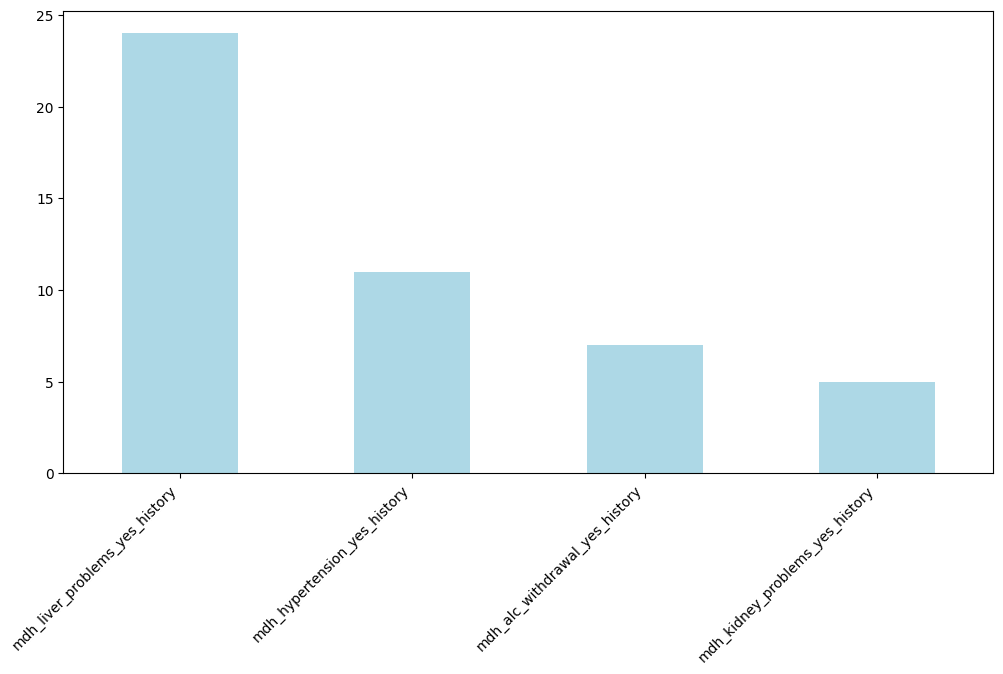

In [93]:
# observe common characteristics for true positive predictions
test_set.loc[test_set.Classification=='TP'][[col for col in test_set.columns if 'mdh_' in col]].sum().sort_values(ascending=False)\
    .plot(kind='bar', color='lightblue', figsize=(12, 6))
plt.xticks(rotation=45, ha='right');

## Addiction Disorder Diagnosis

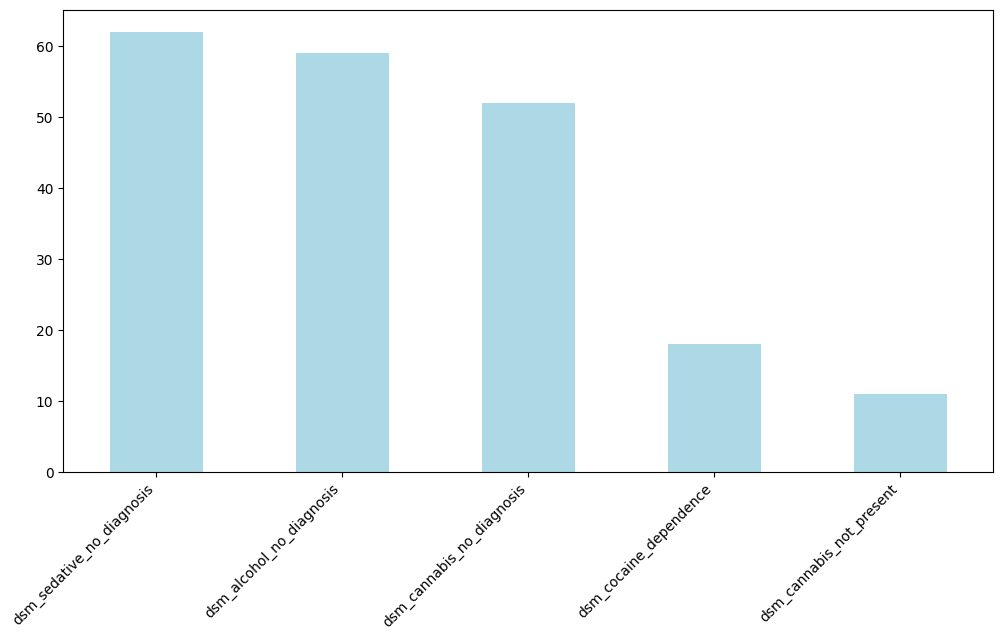

In [94]:
test_set.loc[test_set.Classification=='TP'][[col for col in test_set.columns if 'dsm_' in col]].sum().sort_values(ascending=False)\
    .plot(kind='bar', color='lightblue', figsize=(12, 6))
plt.xticks(rotation=45, ha='right');

## Physical Exam

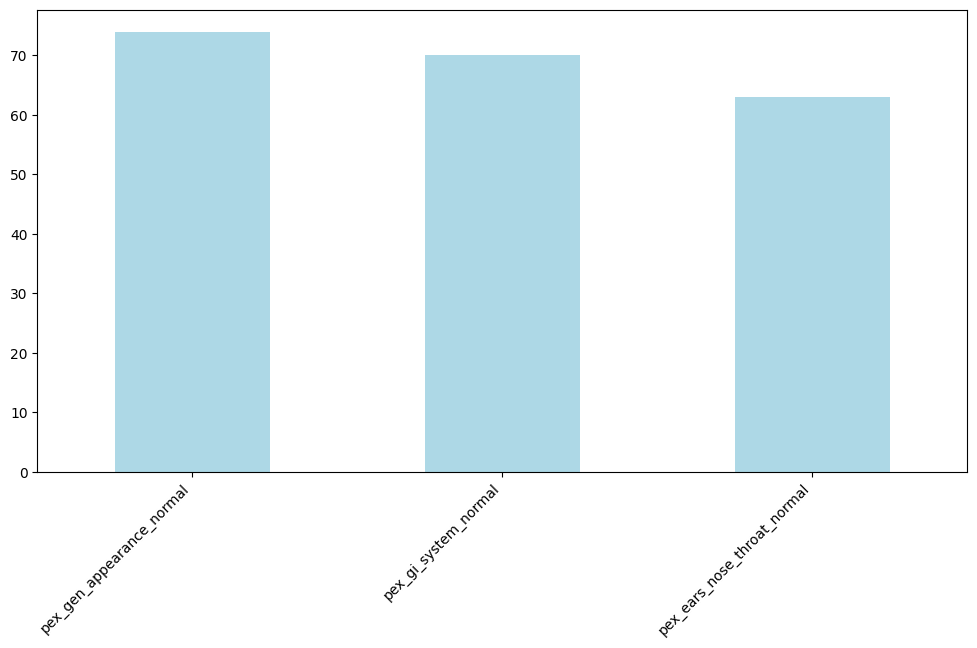

In [95]:
test_set.loc[test_set.Classification=='TP'][[col for col in test_set.columns if 'pex_' in col]].sum().sort_values(ascending=False)\
    .plot(kind='bar', color='lightblue', figsize=(12, 6))
plt.xticks(rotation=45, ha='right');

## Urine Drug Screen

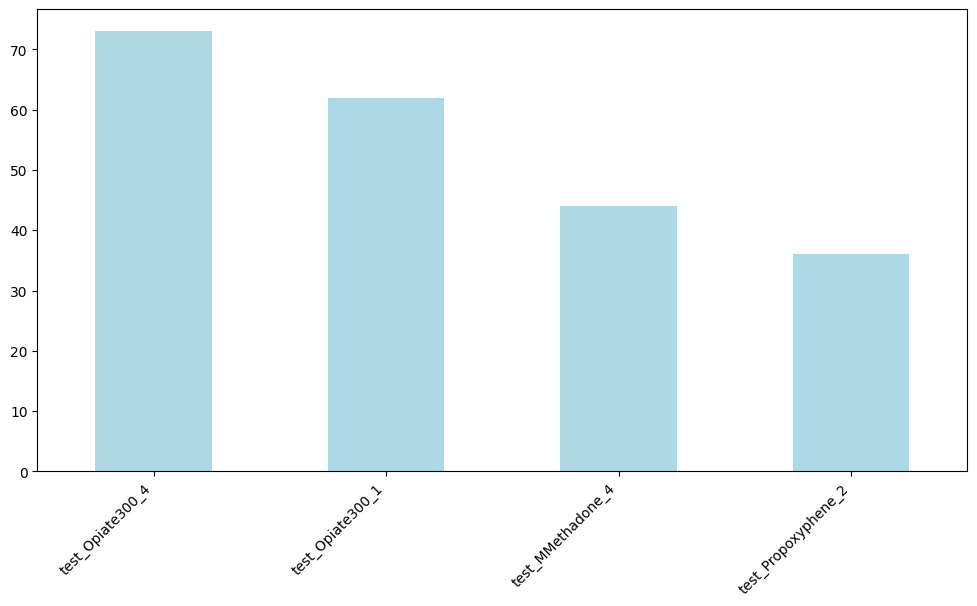

In [96]:
test_set.loc[test_set.Classification=='TP'][[col for col in test_set.columns if 'test_' in col]].sum().sort_values(ascending=False)\
    .plot(kind='bar', color='lightblue', figsize=(12, 6))
plt.xticks(rotation=45, ha='right');

## Self Reported Use (Surveys)

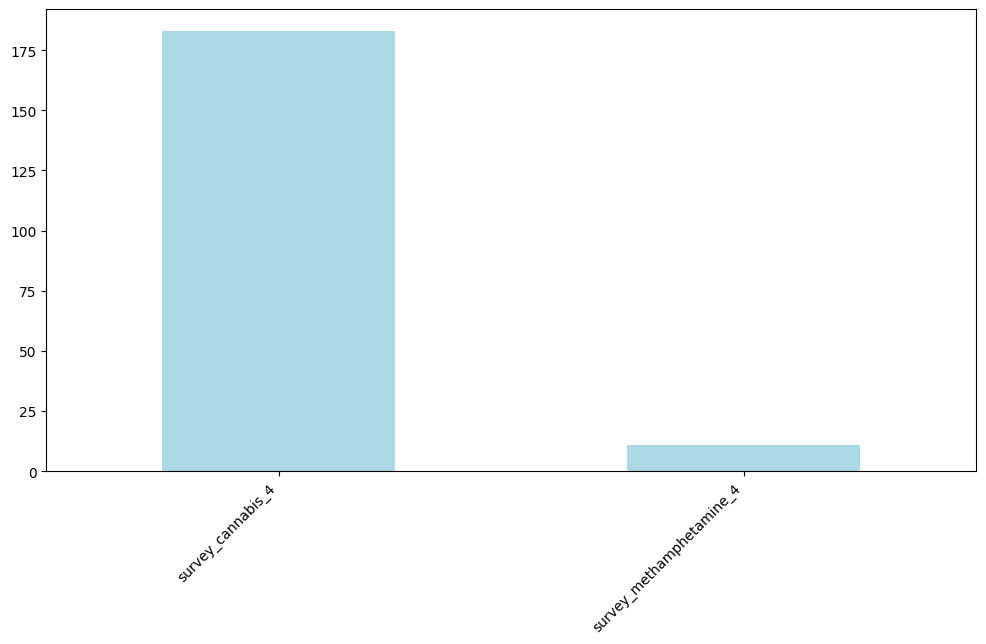

In [97]:
test_set.loc[test_set.Classification=='TP'][[col for col in test_set.columns if 'survey_' in col]].sum().sort_values(ascending=False)\
    .plot(kind='bar', color='lightblue', figsize=(12, 6))
plt.xticks(rotation=45, ha='right');

## Medication Dose (AVG)

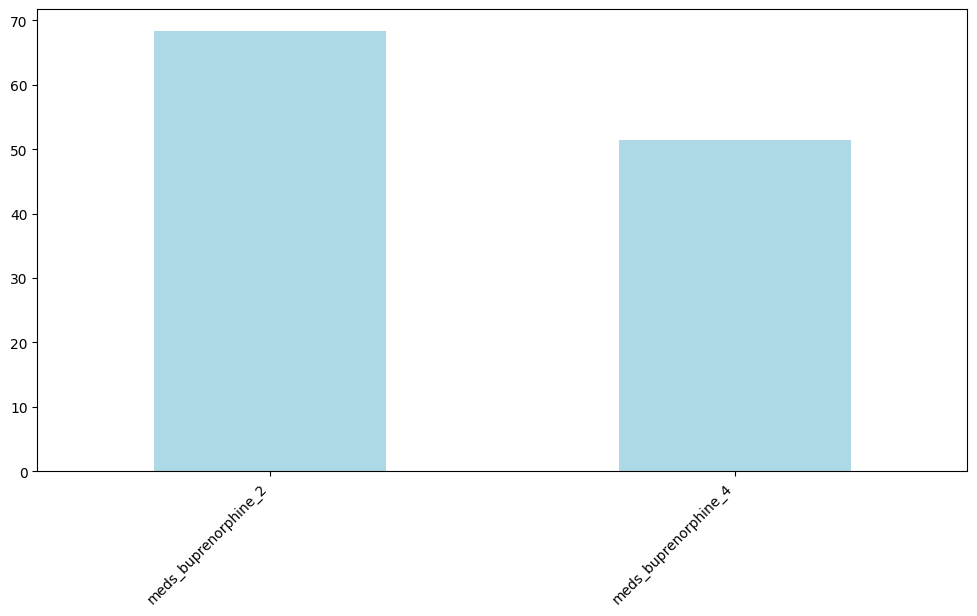

In [98]:
test_set.loc[test_set.Classification=='TP'][[col for col in test_set.columns if 'meds_' in col]].mean().sort_values(ascending=False)\
    .plot(kind='bar', color='lightblue', figsize=(12, 6))
plt.xticks(rotation=45, ha='right');